<a href="https://colab.research.google.com/github/springboardmentor1361k/Smart-Energy-Consumption-Analysis-and-Prediction-using-Machine-Learning-with-Device-Level-Insights-/blob/KARAN-S/data_prerocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

sns.set(style="whitegrid")


In [3]:
df = pd.read_csv("/content/smart_home_energy_consumption_large.csv")

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (100000, 8)


,Home ID,Appliance Type,Energy Consumption (kWh),Time,Date,Outdoor Temperature (°C),Season,Household Size
0,94,Fridge,0.20,21:12,2023-12-02,-1.0,Fall,2
1,435,Oven,0.23,20:11,2023-08-06,31.1,Summer,5
2,466,Dishwasher,0.32,06:39,2023-11-21,21.3,Fall,3
3,496,Heater,3.92,21:56,2023-01-21,-4.2,Winter,1
4,137,Microwave,0.44,04:31,2023-08-26,34.5,Summer,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Home ID                   100000 non-null  int64  
 1   Appliance Type            100000 non-null  object 
 2   Energy Consumption (kWh)  100000 non-null  float64
 3   Time                      100000 non-null  object 
 4   Date                      100000 non-null  object 
 5   Outdoor Temperature (°C)  100000 non-null  float64
 6   Season                    100000 non-null  object 
 7   Household Size            100000 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.1+ MB


In [5]:
print("Missing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())


Missing Values:
 Home ID                     0
Appliance Type              0
Energy Consumption (kWh)    0
Time                        0
Date                        0
Outdoor Temperature (°C)    0
Season                      0
Household Size              0
dtype: int64

Duplicate Rows: 0


In [6]:
df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)

df['timestamp'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    format='mixed',
    errors='coerce'
)

print("Invalid timestamps:", df['timestamp'].isna().sum())
df = df.dropna(subset=['timestamp'])


Invalid timestamps: 0


In [7]:
df = df.sort_values('timestamp')


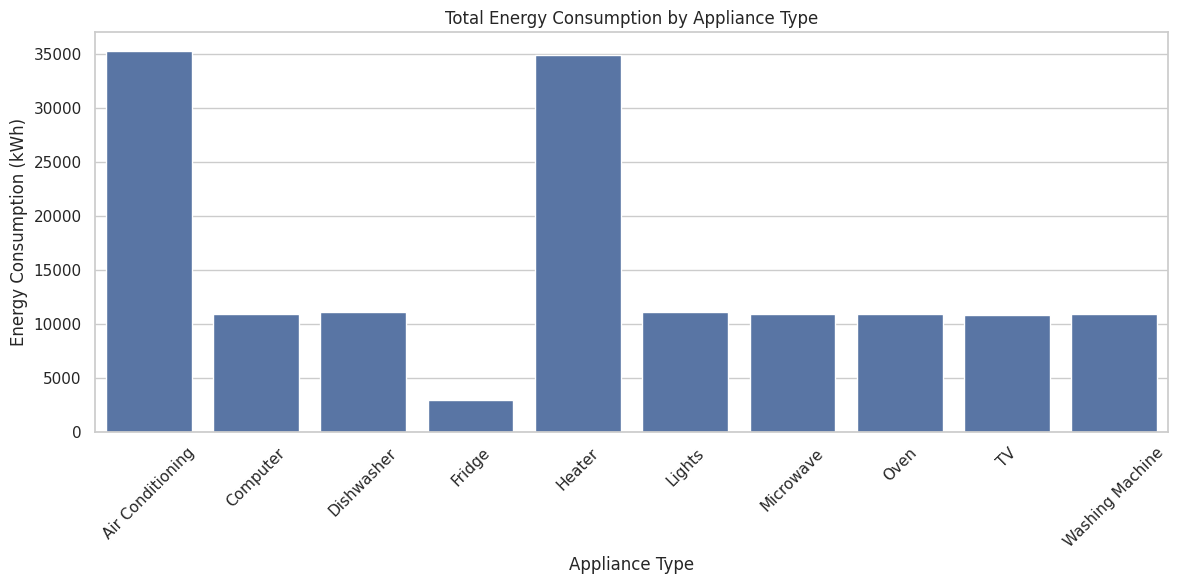

In [8]:
appliance_usage = df.groupby('Appliance Type')['Energy Consumption (kWh)'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=appliance_usage, x='Appliance Type', y='Energy Consumption (kWh)')
plt.title("Total Energy Consumption by Appliance Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


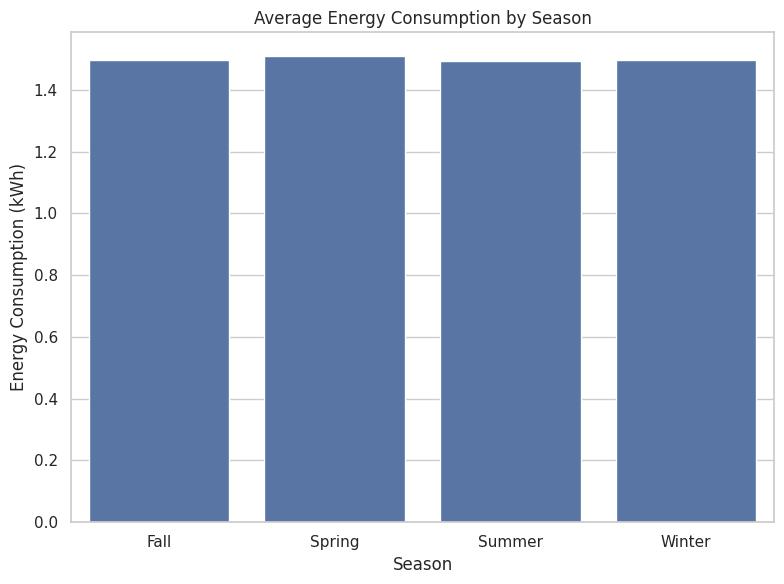

In [9]:
season_usage = df.groupby('Season')['Energy Consumption (kWh)'].mean().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(data=season_usage, x='Season', y='Energy Consumption (kWh)')
plt.title("Average Energy Consumption by Season")
plt.tight_layout()
plt.show()


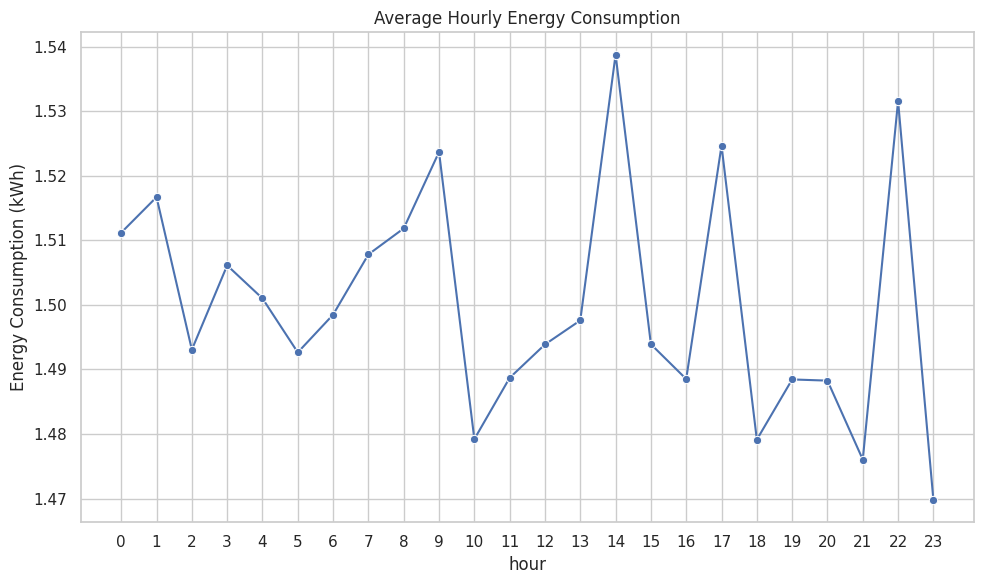

In [10]:
df['hour'] = df['timestamp'].dt.hour
hourly_usage = df.groupby('hour')['Energy Consumption (kWh)'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_usage, x='hour', y='Energy Consumption (kWh)', marker='o')
plt.title("Average Hourly Energy Consumption")
plt.xticks(range(24))
plt.tight_layout()
plt.show()


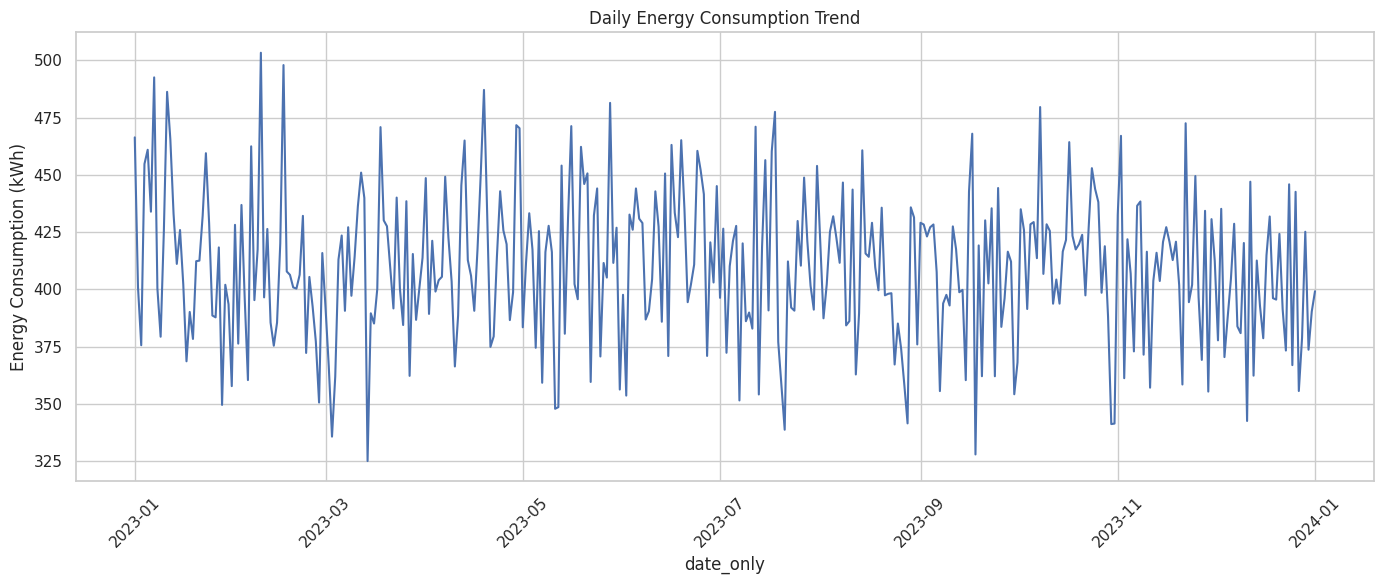

In [11]:
df['date_only'] = df['timestamp'].dt.date
daily_usage = df.groupby('date_only')['Energy Consumption (kWh)'].sum().reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(data=daily_usage, x='date_only', y='Energy Consumption (kWh)')
plt.title("Daily Energy Consumption Trend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
df_avg = (
    df
    .groupby(['Home ID', 'Appliance Type', pd.Grouper(key='timestamp', freq='1h')])
    ['Energy Consumption (kWh)']
    .mean()
    .reset_index()
)

print(df_avg.head())


   Home ID    Appliance Type           timestamp  Energy Consumption (kWh)
0        1  Air Conditioning 2023-01-07 06:00:00                      2.77
1        1  Air Conditioning 2023-01-14 02:00:00                      4.80
2        1  Air Conditioning 2023-01-15 16:00:00                      3.13
3        1  Air Conditioning 2023-01-19 11:00:00                      3.10
4        1  Air Conditioning 2023-01-29 17:00:00                      4.16


In [13]:
df_avg['Energy Consumption (kWh)'] = (
    df_avg['Energy Consumption (kWh)']
    .interpolate(method='linear')
    .ffill()
    .bfill()
)

print("Missing after cleaning:\n", df_avg.isnull().sum())


Missing after cleaning:
 Home ID                     0
Appliance Type              0
timestamp                   0
Energy Consumption (kWh)    0
dtype: int64


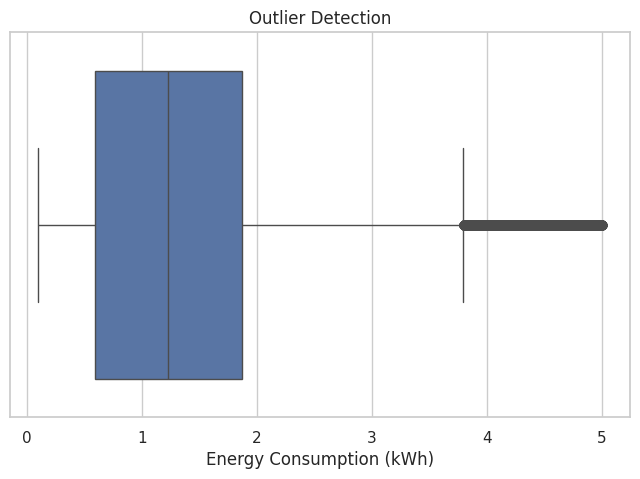

Shape after outlier removal: (91913, 4)


In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df_avg['Energy Consumption (kWh)'])
plt.title("Outlier Detection")
plt.show()

Q1 = df_avg['Energy Consumption (kWh)'].quantile(0.25)
Q3 = df_avg['Energy Consumption (kWh)'].quantile(0.75)
IQR = Q3 - Q1

df_avg = df_avg[
    (df_avg['Energy Consumption (kWh)'] >= Q1 - 1.5 * IQR) &
    (df_avg['Energy Consumption (kWh)'] <= Q3 + 1.5 * IQR)
]

print("Shape after outlier removal:", df_avg.shape)


In [15]:
df_avg['hour'] = df_avg['timestamp'].dt.hour
df_avg['dayofweek'] = df_avg['timestamp'].dt.dayofweek
df_avg['month'] = df_avg['timestamp'].dt.month


In [16]:
appliance_name = "Heater"
appliance_df = df_avg[df_avg['Appliance Type'] == appliance_name]
appliance_df = appliance_df.sort_values('timestamp')

print(appliance_df.head())


       Home ID Appliance Type           timestamp  Energy Consumption (kWh)  \
7847        40         Heater 2023-01-01 02:00:00                      3.69   
79392      398         Heater 2023-01-01 02:00:00                      2.43   
99403      498         Heater 2023-01-01 03:00:00                      2.87   
28475      143         Heater 2023-01-01 03:00:00                      3.28   
32754      164         Heater 2023-01-01 03:00:00                      2.97   

       hour  dayofweek  month  
7847      2          6      1  
79392     2          6      1  
99403     3          6      1  
28475     3          6      1  
32754     3          6      1  


In [17]:
scaler = MinMaxScaler()
appliance_df['energy_scaled'] = scaler.fit_transform(
    appliance_df[['Energy Consumption (kWh)']]
)


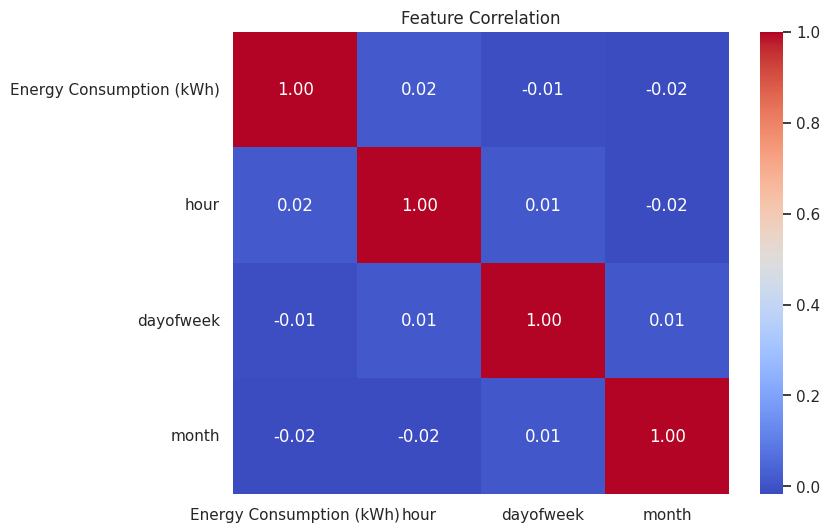

In [18]:
plt.figure(figsize=(8,6))
sns.heatmap(
    appliance_df[['Energy Consumption (kWh)', 'hour', 'dayofweek', 'month']].corr(),
    annot=True, cmap='coolwarm', fmt=".2f"
)
plt.title("Feature Correlation")
plt.show()


In [19]:
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

energy_series = appliance_df['energy_scaled'].values

SEQ_LENGTH = 24
X, y = create_sequences(energy_series, SEQ_LENGTH)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (6042, 24)
y shape: (6042,)


In [20]:
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Train: (4229, 24)
Validation: (906, 24)
Test: (907, 24)


In [21]:
# Lag Features
appliance_df['lag_1'] = appliance_df['Energy Consumption (kWh)'].shift(1)
appliance_df['lag_24'] = appliance_df['Energy Consumption (kWh)'].shift(24)


In [22]:
# Rolling Mean & Std
appliance_df['rolling_mean_24'] = (
    appliance_df['Energy Consumption (kWh)']
    .rolling(window=24)
    .mean()
)

appliance_df['rolling_std_24'] = (
    appliance_df['Energy Consumption (kWh)']
    .rolling(window=24)
    .std()
)


In [23]:
appliance_df = appliance_df.dropna().reset_index(drop=True)
print("Shape after feature engineering:", appliance_df.shape)


Shape after feature engineering: (6042, 12)


In [24]:
FEATURES = [
    'hour',
    'dayofweek',
    'month',
    'lag_1',
    'lag_24',
    'rolling_mean_24',
    'rolling_std_24'
]

TARGET = 'Energy Consumption (kWh)'

X = appliance_df[FEATURES]
y = appliance_df[TARGET]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (6042, 7)
y shape: (6042,)


In [25]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)


In [26]:
split_index = int(0.8 * len(X_scaled))

X_train = X_scaled[:split_index]
X_test = X_scaled[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (4833, 7)
Test size: (1209, 7)


In [27]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

In [28]:
y_pred = lr_model.predict(X_test)


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")


MAE : 0.4425
RMSE: 0.5137
R²  : 0.0161


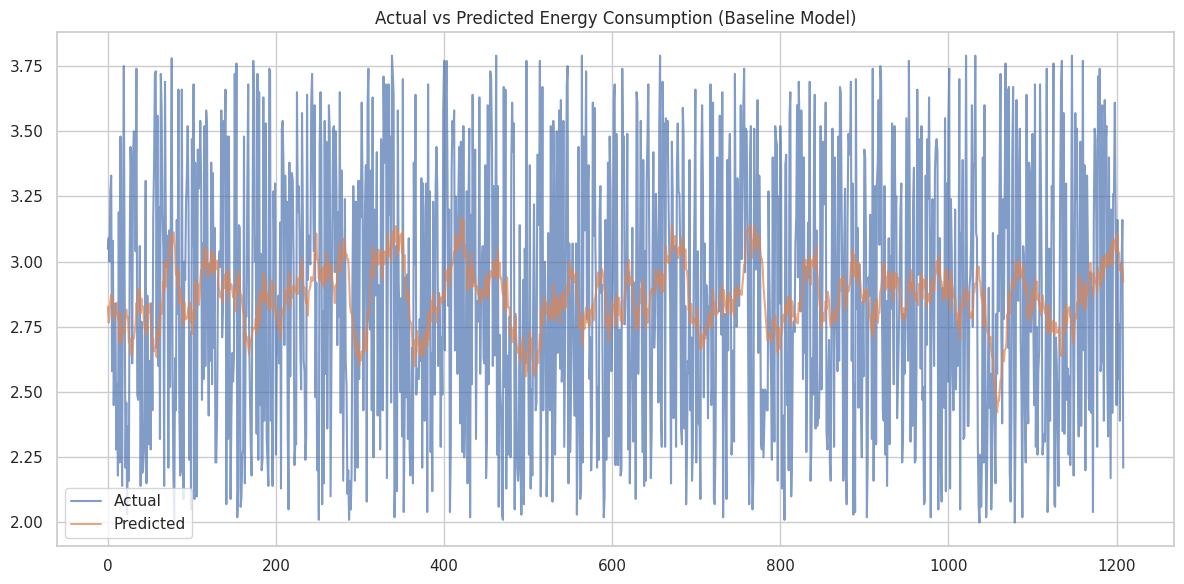

In [30]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title("Actual vs Predicted Energy Consumption (Baseline Model)")
plt.legend()
plt.tight_layout()
plt.show()


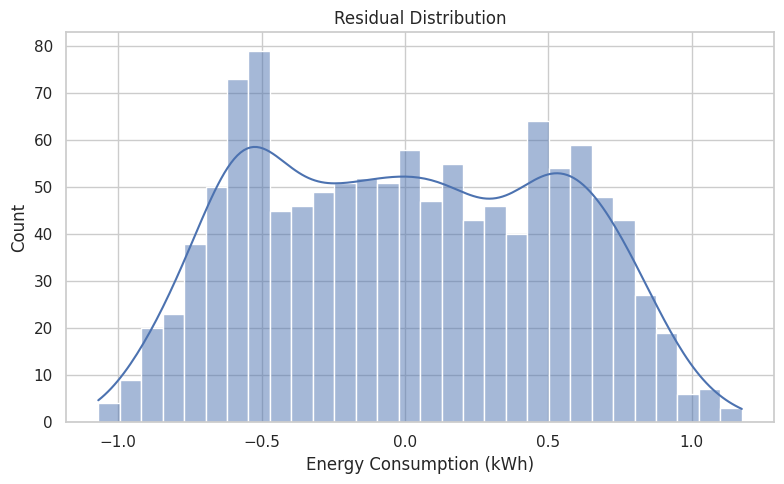

In [31]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()
